In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import urllib
import cv2
from sklearn.model_selection import train_test_split

In [2]:
df= pd.read_csv('data.csv')
df

,img,stage,discharge
0,file:///D:/x/StateLineWeir_20120609_Farrell_00...,2.99,916.0
1,file:///D:/x/StateLineWeir_20120609_Farrell_00...,2.99,916.0
2,file:///D:/x/StateLineWeir_20120609_Farrell_00...,2.96,873.0
3,file:///D:/x/StateLineWeir_20120609_Farrell_00...,2.94,846.0
4,file:///D:/x/StateLineWeir_20120609_Farrell_00...,2.94,846.0
...,...,...,...
41289,file:///D:/x/StateLineWeir_20191011_Farrell_40...,2.54,434.0
41290,file:///D:/x/StateLineWeir_20191011_Farrell_41...,2.54,434.0
41291,file:///D:/x/StateLineWeir_20191011_Farrell_41...,2.54,434.0
41292,file:///D:/x/StateLineWeir_20191011_Farrell_41...,2.54,434.0


In [3]:
img_array = np.load('rio_pro.npy',allow_pickle=True)

In [4]:
X =[]
exclude =[]
for i in range(len(img_array)):
    if img_array[i].shape == (10000,):
        X.append(img_array[i])
    else:
        exclude.append(i)
X =np.array(X)
#also remove from the dataframe
df.drop(df.index[exclude],inplace=True)

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
#Define a Convolutional Neural Network Model
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (100, 100, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                        

In [6]:
save_at = "model_regression.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
#set up the x, y for training 
Y = np.array(df.discharge.tolist())
#X_test = X[300:,]
#Y_test = Y[300:,]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.10, random_state=13)
img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [7]:
history = model.fit( X_train, Y_train, 
                    epochs = 5, batch_size = 200, 
                    callbacks=[save_best2], verbose=1)

Epoch 1/5
186/186 [==============================] - 492s 3s/step - loss: 221410.8281
Epoch 2/5
186/186 [==============================] - 533s 3s/step - loss: 34769.6797
Epoch 3/5
186/186 [==============================] - 519s 3s/step - loss: 28066.2500
Epoch 4/5
186/186 [==============================] - 513s 3s/step - loss: 24932.5723
Epoch 5/5
186/186 [==============================] - 532s 3s/step - loss: 22451.6973


KeyError: 'val_loss'

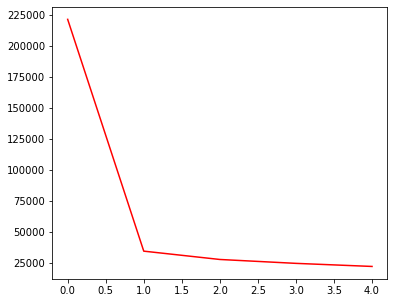

In [14]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()
#125665

130/130 [==============================] - 15s 104ms/step


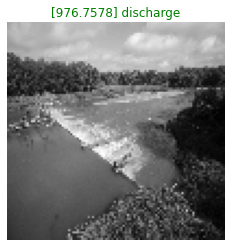

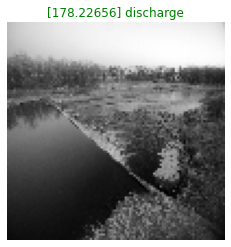

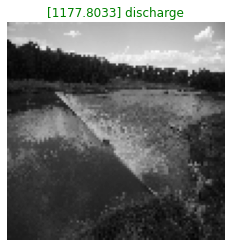

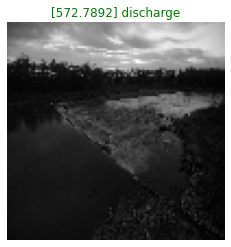

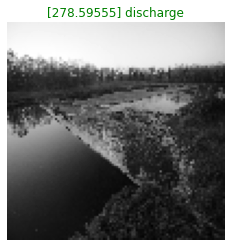

In [9]:
Y_pred = (model.predict(X_val))
np.random.seed(23)
for rand_num in np.random.randint(0, 38, 5):
    plt.figure()
    plt.imshow(X_val[rand_num].reshape(100, 100),cmap='gray'), plt.axis('off')
    plt.title(str(Y_pred[rand_num]) +' discharge', color='g')

In [10]:
Y_pred

array([[221.60883],
       [252.32523],
       [306.70883],
       ...,
       [270.04483],
       [130.51976],
       [258.42044]], dtype=float32)

In [11]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_val, Y_pred)
#699581.0319818744

13027.169448959186